In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

## Fetch the data and load it in pandas

In [2]:
import os
from urllib.request import urlretrieve

url = ("https://archive.ics.uci.edu/ml/machine-learning-databases"
       "/adult/adult.data")
local_filename = os.path.basename(url)
if not os.path.exists(local_filename):
    print("Downloading Adult Census datasets from UCI")
    urlretrieve(url, local_filename)

In [3]:
names = ("age, workclass, fnlwgt, education, education-num, "
         "marital-status, occupation, relationship, race, sex, "
         "capital-gain, capital-loss, hours-per-week, "
         "native-country, income").split(', ')    
data = pd.read_csv(local_filename, names=names)

In [4]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
data.count()

age               32561
workclass         32561
fnlwgt            32561
education         32561
education-num     32561
marital-status    32561
occupation        32561
relationship      32561
race              32561
sex               32561
capital-gain      32561
capital-loss      32561
hours-per-week    32561
native-country    32561
income            32561
dtype: int64

In [6]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
data.groupby('occupation').size().order(ascending=False)

occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
dtype: int64

In [8]:
data.groupby('native-country').size().order(ascending=False)

native-country
 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                  

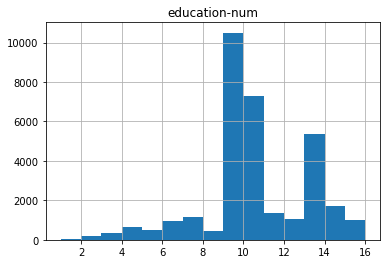

In [9]:
data.hist(column='education-num', bins=15);

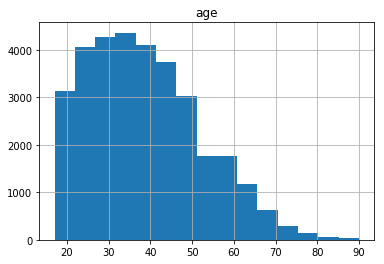

In [10]:
data.hist(column='age', bins=15);

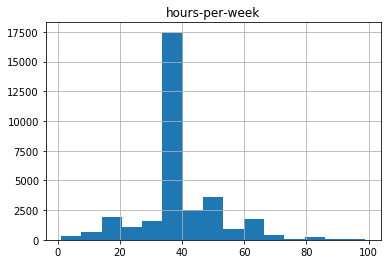

In [11]:
data.hist('hours-per-week', bins=15);

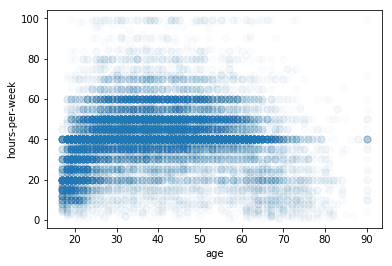

In [12]:
data.plot(x='age', y='hours-per-week', kind='scatter',
          alpha=0.02, s=50);

In [13]:
data.groupby('income')['income'].count()

income
 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [14]:
np.mean(data['income'] == ' >50K')

0.24080955744602439

In [15]:
data['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [16]:
data = data.dropna()

In [17]:
data['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [18]:
target_names = data['income'].unique()
target_names

array([' <=50K', ' >50K'], dtype=object)

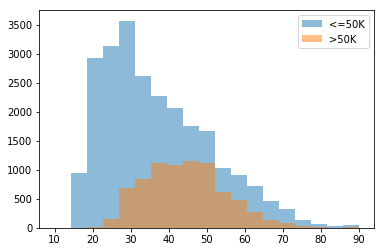

In [19]:
low_income = data[data['income'] == ' <=50K']
high_income = data[data['income'] == ' >50K']

bins = np.linspace(10, 90, 20)
plt.hist(low_income['age'].values, bins=bins, alpha=0.5, label='<=50K')
plt.hist(high_income['age'].values, bins=bins, alpha=0.5, label='>50K')
plt.legend(loc='best');

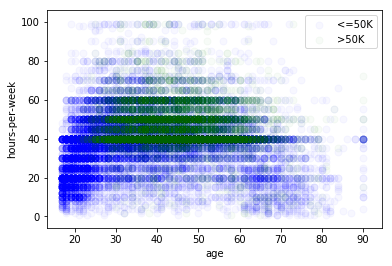

In [20]:
plt.scatter(low_income['age'], low_income['hours-per-week'],
            alpha=0.03, s=50, c='b', label='<=50K');
plt.scatter(high_income['age'], high_income['hours-per-week'],
            alpha=0.03, s=50, c='g', label='>50K');
plt.legend()
plt.xlabel('age'); plt.ylabel('hours-per-week');

## Building predictive models

In [21]:
target = data['income']
features_data = data.drop('income', axis=1)

In [22]:
numeric_features = [c for c in features_data if features_data[c].dtype.kind in ('i', 'f')]
numeric_features

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [23]:
numeric_data = features_data[numeric_features]
numeric_data.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [24]:
categorical_data = features_data.drop(numeric_features, 1)
categorical_data.head(5)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [25]:
categorical_data_encoded = categorical_data.apply(lambda x: pd.factorize(x)[0])
categorical_data_encoded.head(5)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,0,0
2,2,1,2,2,0,0,0,0
3,2,2,1,2,1,1,0,0
4,2,0,1,3,2,1,1,1


In [26]:
features = pd.concat([numeric_data, categorical_data_encoded], axis=1)
features.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,0
1,50,83311,13,0,0,13,1,0,1,1,1,0,0,0
2,38,215646,9,0,0,40,2,1,2,2,0,0,0,0
3,53,234721,7,0,0,40,2,2,1,2,1,1,0,0
4,28,338409,13,0,0,40,2,0,1,3,2,1,1,1


In [27]:
# Alternatively: use one-hot encoding for categorical features
# features = pd.get_dummies(features_data)
# features.head()

In [28]:
X = features.values.astype(np.float32)
y = (target.values == ' >50K').astype(np.int32)

In [29]:
X.shape

(32561, 14)

In [30]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(max_depth=8)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
print("ROC AUC Decision Tree: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

ROC AUC Decision Tree: 0.8965 +/-0.0037


## Model error analysis

In [33]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    plt.title("Learning curves for %s" % type(estimator).__name__)
    plt.ylim(*ylim); plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Best validation score: {:.4f}".format(validation_scores_mean[-1]))

Best validation score: 0.7476


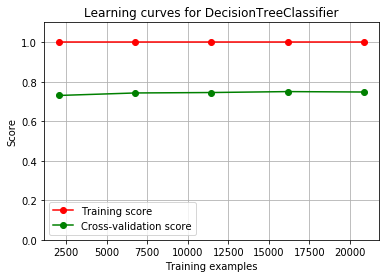

In [34]:
clf = DecisionTreeClassifier(max_depth=None)
plot_learning_curve(clf, X_train, y_train, scoring='roc_auc')

Best validation score: 0.8584


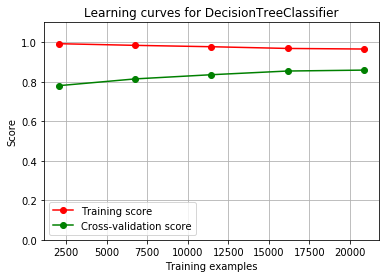

In [35]:
clf = DecisionTreeClassifier(max_depth=15)
plot_learning_curve(clf, X_train, y_train, scoring='roc_auc')

Best validation score: 0.8969


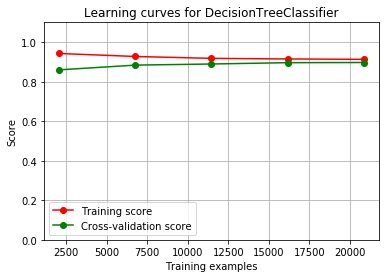

In [36]:
clf = DecisionTreeClassifier(max_depth=8)
plot_learning_curve(clf, X_train, y_train, scoring='roc_auc')

Best validation score: 0.8636


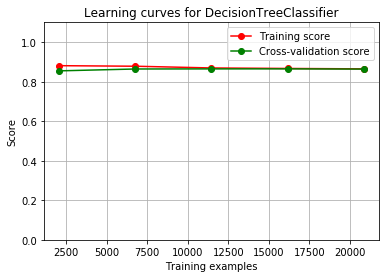

In [37]:
clf = DecisionTreeClassifier(max_depth=4)
plot_learning_curve(clf, X_train, y_train, scoring='roc_auc')

In [41]:
from sklearn.model_selection import validation_curve


def plot_validation_curve(estimator, X, y, param_name, param_range,
                          ylim=(0, 1.1), cv=5, n_jobs=-1, scoring=None):
    estimator_name = type(estimator).__name__
    plt.title("Validation curves for %s on %s"
              % (param_name, estimator_name))
    plt.ylim(*ylim); plt.grid()
    plt.xlim(min(param_range), max(param_range))
    plt.xlabel(param_name)
    plt.ylabel("Score")

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name, param_range,
        cv=cv, n_jobs=n_jobs, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.semilogx(param_range, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.semilogx(param_range, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")
    print("Best test score: {:.4f}".format(test_scores_mean[-1]))

Best test score: 0.7519


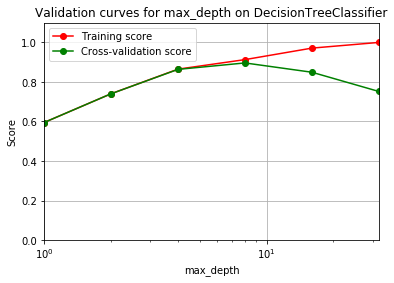

In [42]:
clf = DecisionTreeClassifier(max_depth=8)
param_name = 'max_depth'
param_range = [1, 2, 4, 8, 16, 32]

plot_validation_curve(clf, X_train, y_train,
                      param_name, param_range, scoring='roc_auc')

## Gradient Boosted Decision Trees

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=30, max_features=10,
                             max_depth=10)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc',
                         n_jobs=-1)
print("ROC Random Forest: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

ROC Random Forest: 0.9140 +/-0.0031


In [44]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_leaf_nodes=5, learning_rate=0.1,
                                 n_estimators=100)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc',
                         n_jobs=-1)
print("ROC AUC Gradient Boosted Trees: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

ROC AUC Gradient Boosted Trees: 0.9183 +/-0.0030


## Evaluation of the best model

In [45]:
%%time
_ = clf.fit(X_train, y_train)

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 2.1 s


In [46]:
from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[:, 1]
print("ROC AUC: %0.4f" % roc_auc_score(y_test, y_pred_proba))

ROC AUC: 0.9164


In [47]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      <=50K       0.88      0.95      0.91      4918
       >50K       0.78      0.59      0.67      1595

avg / total       0.85      0.86      0.85      6513



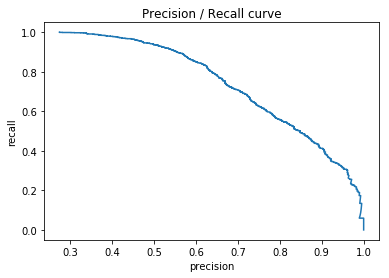

In [48]:
from sklearn.metrics import precision_recall_curve

precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(precision_gb, recall_gb)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision / Recall curve');

## Variable importances

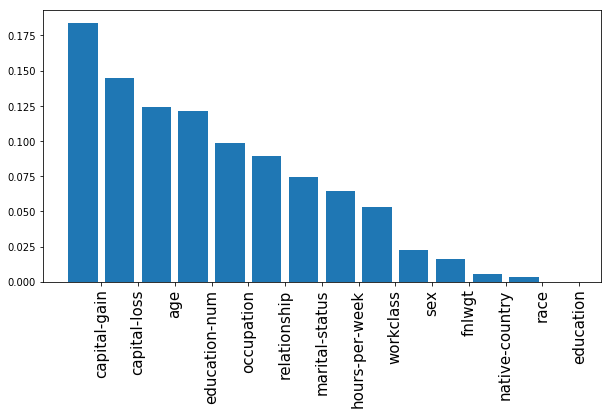

In [49]:
plt.figure(figsize=(10, 5))

ordering = np.argsort(clf.feature_importances_)[::-1]

importances = clf.feature_importances_[ordering]
feature_names = features.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Using the boosted trees to extract features for a Logistic Regression model

The following is an implementation of a trick found in:

Practical Lessons from Predicting Clicks on Ads at Facebook
Junfeng Pan, He Xinran, Ou Jin, Tianbing XU, Bo Liu, Tao Xu, Yanxin Shi, Antoine Atallah, Ralf Herbrich, Stuart Bowers, Joaquin Quiñonero Candela
International Workshop on Data Mining for Online Advertising (ADKDD)

https://www.facebook.com/publications/329190253909587/

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack


class TreeTransform(BaseEstimator, TransformerMixin):
    """One-hot encode samples with an ensemble of trees
    
    This transformer first fits an ensemble of trees (e.g. gradient
    boosted trees or a random forest) on the training set.

    Then each leaf of each tree in the ensembles is assigned a fixed
    arbitrary feature index in a new feature space. If you have 100
    trees in the ensemble and 2**3 leafs per tree, the new feature
    space has 100 * 2**3 == 800 dimensions.
    
    Each sample of the training set go through the decisions of each tree
    of the ensemble and ends up in one leaf per tree. The sample if encoded
    by setting features with those leafs to 1 and letting the other feature
    values to 0.
    
    The resulting transformer learn a supervised, sparse, high-dimensional
    categorical embedding of the data.
    
    This transformer is typically meant to be pipelined with a linear model
    such as logistic regression, linear support vector machines or
    elastic net regression.
    
    """

    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.fit_transform(X, y)
        return self
        
    def fit_transform(self, X, y):
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y)
        self.binarizers_ = []
        sparse_applications = []
        estimators = np.asarray(self.estimator_.estimators_).ravel()
        for t in estimators:
            lb = LabelBinarizer(sparse_output=True)
            sparse_applications.append(lb.fit_transform(t.tree_.apply(X)))
            self.binarizers_.append(lb)
        return hstack(sparse_applications)
        
    def transform(self, X, y=None):
        sparse_applications = []
        estimators = np.asarray(self.estimator_.estimators_).ravel()
        for t, lb in zip(estimators, self.binarizers_):
            sparse_applications.append(lb.transform(t.tree_.apply(X)))
        return hstack(sparse_applications)


boosted_trees = GradientBoostingClassifier(
    max_leaf_nodes=5, learning_rate=0.1,
    n_estimators=100, random_state=0,
) 

pipeline = make_pipeline(
    TreeTransform(boosted_trees),
    LogisticRegression(C=1)
)

pipeline.fit(X_train, y_train);

In [51]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print("ROC AUC: %0.4f" % roc_auc_score(y_test, y_pred_proba))

ROC AUC: 0.9233


In [52]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      <=50K       0.89      0.93      0.91      4918
       >50K       0.76      0.66      0.70      1595

avg / total       0.86      0.86      0.86      6513



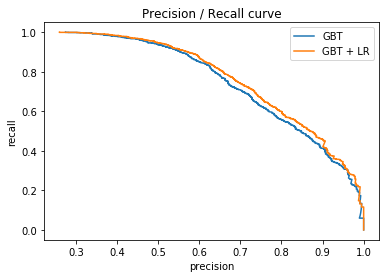

In [53]:
from sklearn.metrics import precision_recall_curve

precision_gb_lr, recall_gb_lr, _ = precision_recall_curve(
    y_test, y_pred_proba)

plt.plot(precision_gb, recall_gb, label='GBT')
plt.plot(precision_gb_lr, recall_gb_lr, label='GBT + LR')
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision / Recall curve')
plt.legend();